AssertionError: 

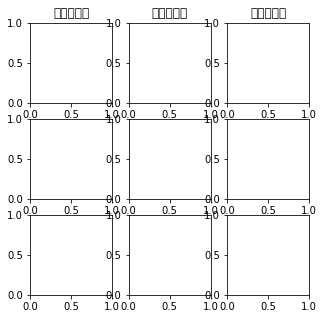

In [4]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals, division

import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import matplotlib.cm as cm


class HopfieldNetwork(object):
    threshold = 0

    def fit(self, train_list):
        """
        初期化: 学習データから重み行列を初期化
        """
        self.dim = len(train_list[0])

        n = len(train_list)
        self.W = np.zeros((self.dim, self.dim))
        rho = np.sum([np.sum(t) for t in train_list]) / (n * self.dim)
        for m in range(n):
            # データ全体の平均値にあわせてシフト
            t = train_list[m] - rho
            self.W += np.outer(t, t)
        for i in range(self.dim):
            self.W[i, i] = 0
        self.W /= n

    def predict(self, data, threshold=0, loop=10):
        """
        更新: 入力値のリストに対し、出力値のリストを返す
        """
        self.threshold = threshold
        return [self._predict(d, loop=loop) for d in data]

    def _predict(self, xr, loop=10):
        """
        個々の入力値に対し、ユニットの値が収束するまで =
        エネルギーが変化しなくなるまで更新を行う
        """
        e = self.energy(xr)
        for i in range(loop):
            xr = self.W.dot(xr) - self.threshold
            # xr の符号をとる
            xr = np.sign(xr)
            e_new = self.energy(xr)
            if e == e_new:
                return xr
            e = e_new
        return xr

    def energy(self, xr):
        """
        ユニットの状態からネットワークのエネルギーを計算
        """
        return - xr.dot(self.W).dot(xr) + np.sum(xr * self.threshold)

    def plot_weight(self):
        """
        重み行列をヒートマップとしてプロット
        """
        fig, ax = plt.subplots(figsize=(5, 3))
        heatmap = ax.pcolor(self.W, cmap=cm.coolwarm)
        cbar = plt.colorbar(heatmap)

        ax.set_xlim(0, self.dim)
        ax.set_ylim(0, self.dim)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        return fig, ax

    def plot_data(self, ax, data, with_energy=False):
        """
        data を画像化 (2次元化) して ax にプロット
        """
        dim = int(np.sqrt(len(data)))
        # このサンプルで扱う画像は縦横 同じ長さのもののみ
        assert dim * dim == len(data)

        img = (data.reshape(dim, dim) + 1) / 2
        ax.imshow(img, cmap=cm.Greys_r, interpolation='nearest')
        if with_energy:
            e = np.round(self.energy(data), 1)
            ax.text(0.95, 0.05, e, color='r', ha='right',
                    transform=ax.transAxes)
        return ax


# ユーティリティ関数

def get_corrupted_input(input, corruption_level):
    """
    入力にノイズを付与
    """
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def plot(hn, data, test, predicted, figsize=(5, 7)):
    """
    元データ、テストデータ、推測値を描画
    """
    fig, axes = plt.subplots(len(data), 3, figsize=figsize)
    for i, axrow in enumerate(axes):
        if i == 0:
            axrow[0].set_title('学習データ')
            axrow[1].set_title('入力データ')
            axrow[2].set_title('出力データ')
        hn.plot_data(axrow[0], data[i])
        hn.plot_data(axrow[1], test[i], with_energy=True)
        hn.plot_data(axrow[2], predicted[i], with_energy=True)

        for ax in axrow:
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
    return fig, axes

data = [np.array([  0, 0, 0, 0, 0, 0, 0,
                    0, +1, +1, +1, +1, +1,  0,
                    0,  0,  0,  0,  0, +1,  0,
                    0,  0,  0,  0,  0, +1,  0,
                    0, +1, +1, +1, +1, +1,  0,  
                    0, +1,  0,  0,  0,  0,  0,
                    0, +1,  0,  0,  0,  0,  0,
                    0, +1, +1, +1, +1, +1,  0,
                    0,  0,  0,  0,  0,  0,  0]),

        np.array([  0, 0, 0, 0, 0, 0, 0,
                    0,+1,+1,+1,+1,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1,+1,+1,+1,+1, 0,
                    0, 0, 0, 0, 0,+1, 0,
                    0, 0, 0, 0, 0,+1, 0,
                    0, 0, 0, 0, 0,+1, 0,
                    0, 0, 0, 0, 0, 0, 0]),
        np.array([  0, 0, 0, 0, 0, 0, 0,
                    0,+1,+1,+1,+1,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1,+1,+1,+1,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1, 0, 0, 0,+1, 0,
                    0,+1,+1,+1,+1,+1, 0,
                    0, 0, 0, 0, 0, 0, 0])]
           
data = [d * 2 - 1 for d in data]

# Hopfield Network インスタンスの作成 & 学習
hn = HopfieldNetwork()
hn.fit(data)

# 画像に 10% のノイズを付与し、テストデータとする
test = [get_corrupted_input(d, 0.1) for d in data]
# Hopfield Network からの出力
predicted = hn.predict(test)

plot(hn, data, test, predicted, figsize=(5, 5))